In [4]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import pandas as pd
import scipy.stats
import tensorflow as tf
#import tensorflow_probability as tfp

import scanpy as sc
import matplotlib as mpl

print()
print("numpy version "+np.__version__)
print("tensorflow version "+tf.__version__)
#print("tensorflow_probability version "+tfp.__version__)


import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)


numpy version 1.19.2
tensorflow version 2.2.0
batchglm version v0.7.4
diffpy version v0.7.4


In [256]:
annot = sc.read_h5ad('/Users/derekbogdanoff/projects/XYZeq/new_h5s/Processed_Liver_All_Batches_mouse_deconV2_spatial.h5ad')

In [257]:
adata_matrix = sc.read_h5ad('/Users/derekbogdanoff/projects/XYZeq/new_h5s/Liver_All_Batches_mouse_deconV2_raw_counts.h5ad')

In [258]:
adata = adata_matrix[adata_matrix.obs.index.isin(annot.obs.index.to_list())]


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [259]:
##set annotations
adata.obs = annot.obs

adata.uns = annot.uns

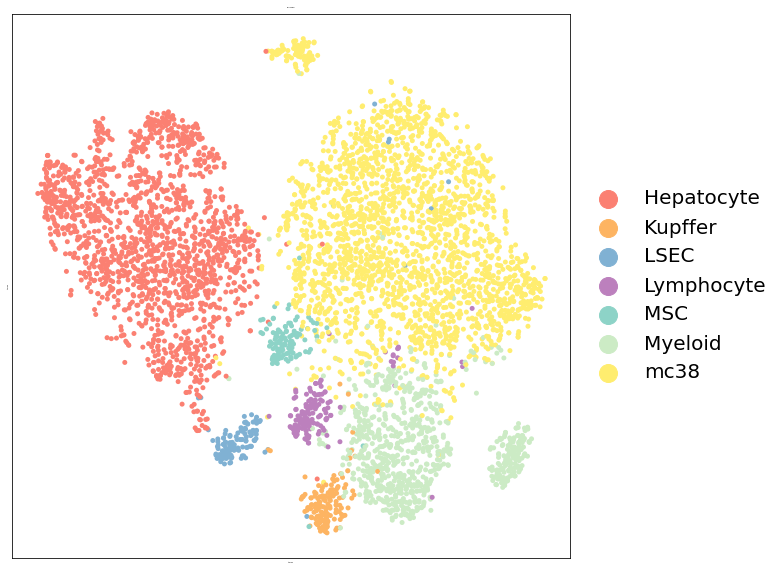

In [260]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 2
plt.rcParams['axes.titlesize'] = 2


sc.pl.tsne(adata,
          color=['CellType'],
        #  legend_loc = 'on data',
           s=100
          )



In [261]:
###define binary spatial annotations using proximity score

def label_race(row):
   if row['prox_2'] >= 0.5 :
      return 'liver'
   if row['prox_2'] < 0.5 : 
      return 'tumor'
   else:
      return 'None'
    
### ..and apply them

adata.obs['tissue'] = adata.obs.apply(lambda row: label_race(row), axis=1)

In [263]:
###read spatial annotations with George's new annotations

regions = pd.read_csv('/Users/derekbogdanoff/projects/XYZeq/regions_files/liver.regions.csv',
           index_col=0)



In [264]:
###define regions offsets

regions['Y'] = -regions['Y']

tmp=[]

for index, row in regions.iterrows():
    if row['X']%2==0:
        m=row['Y'] - .5
        tmp.append(m)
    else:
        tmp.append(row['Y'])
        
regions['Y_offset'] = pd.DataFrame(tmp)

# regions = regions.drop(['Y'],axis=1)



In [265]:
regions = regions.drop(['Y'],axis=1)

regions.columns = ['batch','X','region','Y']

regions['batch'] = regions['batch'].astype('category')

In [266]:
regions['batch'].cat.rename_categories(
                    {0:'L10C',1:'L20C',2:'L20T',3:'L30C'},
                    inplace=True
                    )

In [267]:
cols = ['batch','X','Y','region']
regions = regions[cols]

In [268]:
regions['region'] = regions['region'].astype('string')

In [269]:
# regions['region'].cat.rename_categories(
#                     {-1:'region_1',0:'region_2',1:'region_3',2:'region_4'},
#                     inplace=True
#                     )

In [270]:
# regions.region.unique()

In [271]:
regions.region

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
3019    -1
3020    -1
3021    -1
3022    -1
3023    -1
Name: region, Length: 3024, dtype: string

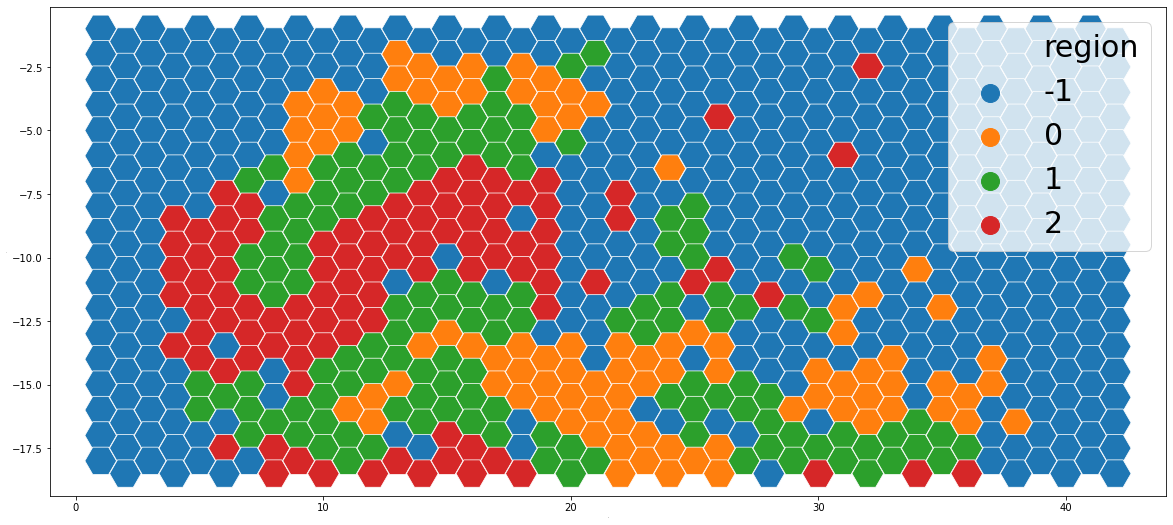

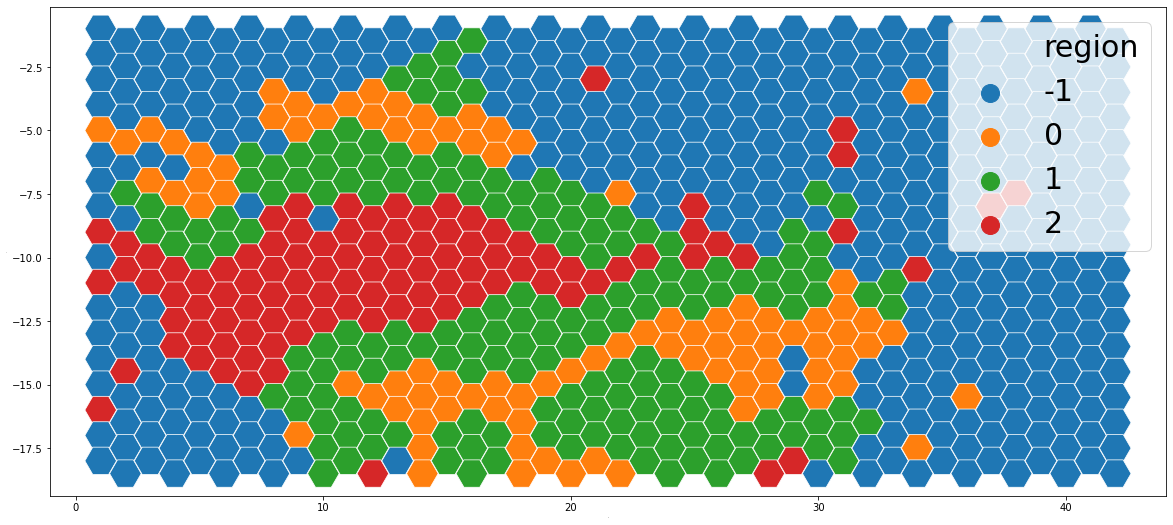

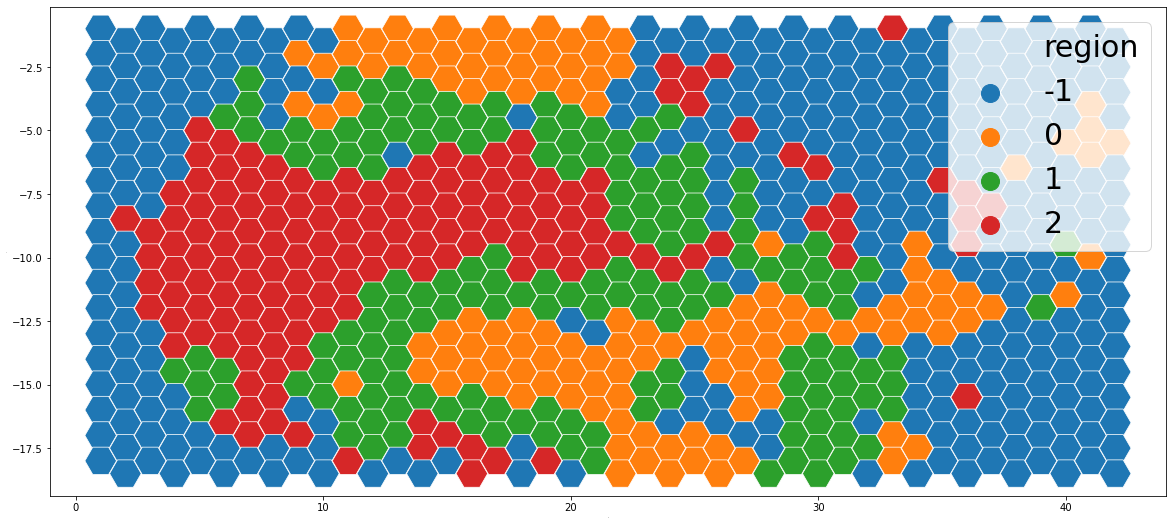

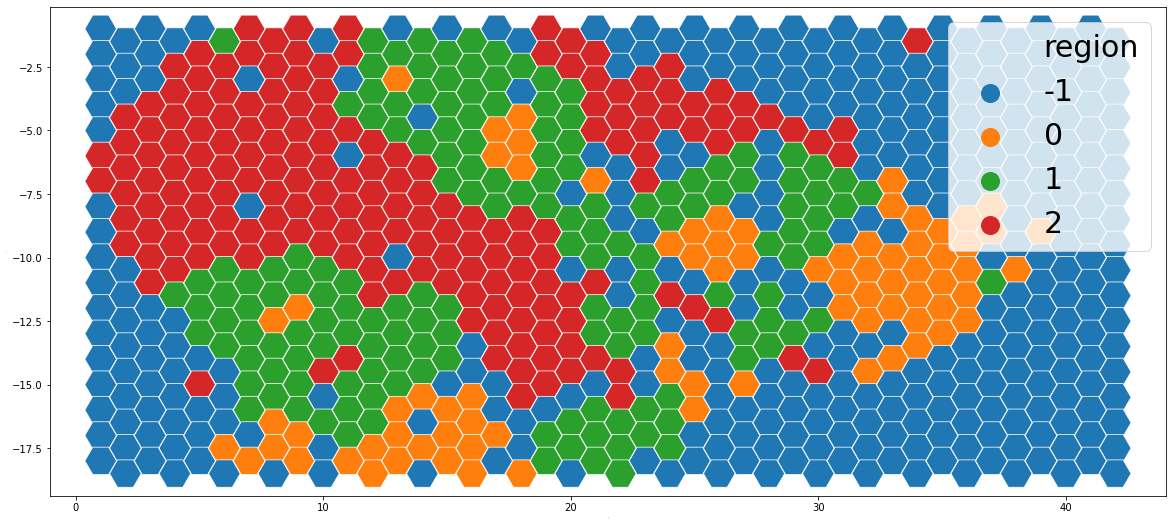

In [272]:
plt.rcParams['figure.figsize'] = [20, 9]

plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 0
plt.rcParams['axes.titlesize'] = 30


for i in regions['batch'].unique():
    g = sns.scatterplot(data=regions[regions['batch'] == i],
                x='X',
                y='Y',
                marker="H",
                s=1000,
                hue='region',
                palette='tab10',
                legend='brief'
                        ###for solid colors:
                #c=[cell_type_color]#[adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()]

               )
    plt.show()



In [273]:
###apply tissue annotations to adata 

adata.obs = adata.obs.reset_index().merge(
    regions, on=['batch','X','Y'],how='left').set_index('index')

In [274]:
adata.obs['region'] = adata.obs['region'].astype('category')

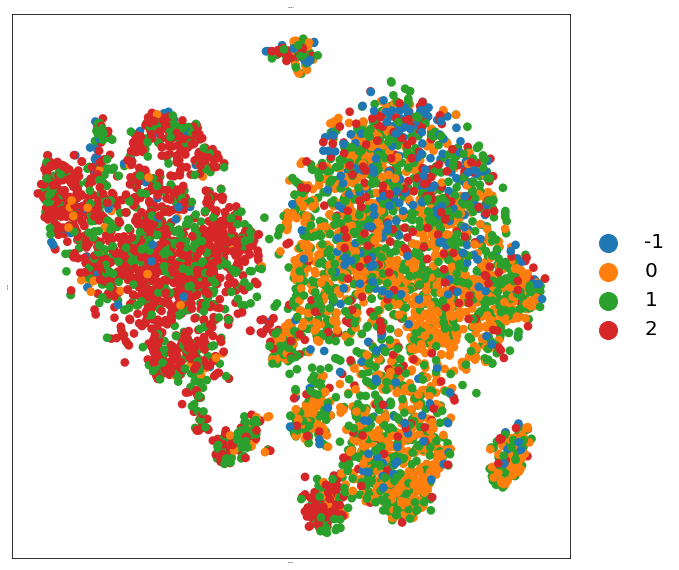

In [481]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 2
plt.rcParams['axes.titlesize'] = 2


sc.pl.tsne(adata,
          color=['region'
                ],
         # legend_loc = 'on data',
           s=300
          )

In [276]:
##filter out human genes

adata = adata[:,adata.var_names.str.startswith('mm10_')]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [278]:
###generate size factors
### try this with R SCRAN - compare results with scanpy..?


# size_factors = sc.pp.normalize_total(adata_norm,
#                          inplace=False,
#                          )['norm_factor']


# adata_norm.obs['size_factors'] = pd.DataFrame(size_factors,
#                                         index=adata_norm.obs.index)

In [414]:
###define binary spatial annotations for testing

def label_race(row):
   if row['region'] == '-1' :
      return 'liver'
   if row['region'] == '0' :
      return 'liver'
   if row['region'] == '1' :
      return 'tumor'
   if row['region'] == '2' :
      return 'tumor'



In [415]:
adata.obs['tissue'] = adata.obs.apply(lambda row: label_race(row), axis=1)

Trying to set attribute `.obs` of view, copying.


In [416]:
##create log normalized data
adata_norm = sc.pp.log1p(adata, copy=True)

In [424]:
#create celltype specific matrices

for i in adata.obs['CellType'].unique():
     locals()["adata_"+str(i)] = adata[adata.obs['CellType'] == i]
        

for i in adata_norm.obs['CellType'].unique():
     locals()["adata_norm_"+str(i)] = adata_norm[adata_norm.obs['CellType'] == i]
     

     
    
    
    
    

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# Diffxpy DE


In [466]:
#run wilcoxon test on the cell types


for i in [adata_norm_Hepatocyte,
         adata_norm_Kupffer,
         adata_norm_LSEC,
         adata_norm_Lymphocyte,
         adata_norm_mc38,
         adata_norm_MSC,
         adata_norm_Myeloid
         ]:
    
    name = i.obs.CellType.cat.categories.item()
    locals()["test_rank_"+name] = de.test.rank_test(
                    data=i.X,
                    sample_description=i.obs,
                    gene_names=i.var_names,
                    grouping='tissue',
                    is_logged=True


    )

In [473]:
#run wald test on the cell types


for i in [adata_norm_Hepatocyte,
         #adata_norm_Kupffer,
         #adata_norm_LSEC,
         #adata_norm_Lymphocyte,
         #adata_norm_mc38,
         #adata_norm_MSC,
         #adata_norm_Myeloid
         ]:
    
    name = i.obs.CellType.cat.categories.item()
    
    locals()["wald_test_"+name] = de.test.wald(
        data=i.X,
        sample_description=i.obs,
        gene_names=i.var_names,
        formula_loc="~ 1 + tissue",
        formula_scale="~ 1",
        factor_loc_totest="tissue",
        dtype='float64',
        backend='numpy'
    )



training location model: False
training scale model: True
iter   0: ll=54511833.804299
iter   1: ll=54511833.804299, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=2824635.383024, converged: 21.89% (loc: 21.89%, scale update: True), in 107.69sec
iter   3: ll=2824635.383024, converged: 21.89% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=2573280.726240, converged: 74.28% (loc: 74.28%, scale update: True), in 79.97sec
iter   5: ll=2573280.726240, converged: 74.28% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=2528973.606664, converged: 92.96% (loc: 92.96%, scale update: True), in 48.92sec
iter   7: ll=2528973.606664, converged: 92.96% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=2520798.953936, converged: 98.49% (loc: 98.49%, scale update: True), in 41.61sec
iter   9: ll=2520798.953936, converged: 98.49% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=2519380.172191, converged: 99.73% (loc: 99.73%, 

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/array/core.py:2707: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


training location model: False
training scale model: True
iter   0: ll=4874101.062883
iter   1: ll=4874101.062883, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=294817.397351, converged: 58.75% (loc: 58.75%, scale update: True), in 40.13sec
iter   3: ll=294817.397351, converged: 58.75% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=256820.867191, converged: 83.00% (loc: 83.00%, scale update: True), in 20.13sec
iter   5: ll=256820.867191, converged: 83.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=251348.390137, converged: 95.91% (loc: 95.91%, scale update: True), in 11.70sec
iter   7: ll=251348.390137, converged: 95.91% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=249642.758773, converged: 99.05% (loc: 99.05%, scale update: True), in 8.34sec
iter   9: ll=249642.758773, converged: 99.05% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=249395.717571, converged: 99.86% (loc: 99.86%, scale update:

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/array/core.py:2707: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


training location model: False
training scale model: True
iter   0: ll=4109981.086050
iter   1: ll=4109981.086050, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=343033.537611, converged: 55.60% (loc: 55.60%, scale update: True), in 38.70sec
iter   3: ll=343033.537611, converged: 55.60% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=303658.293608, converged: 82.57% (loc: 82.57%, scale update: True), in 19.86sec
iter   5: ll=303658.293608, converged: 82.57% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=298459.053784, converged: 96.12% (loc: 96.12%, scale update: True), in 11.08sec
iter   7: ll=298459.053784, converged: 96.12% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=297181.190557, converged: 99.21% (loc: 99.21%, scale update: True), in 6.71sec
iter   9: ll=297181.190557, converged: 99.21% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=297095.800607, converged: 99.92% (loc: 99.92%, scale update:

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/array/core.py:2707: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


training location model: False
training scale model: True
iter   0: ll=5223954.672675
iter   1: ll=5223954.672675, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=262096.872134, converged: 51.69% (loc: 51.69%, scale update: True), in 37.74sec
iter   3: ll=262096.872134, converged: 51.69% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=234435.158404, converged: 85.93% (loc: 85.93%, scale update: True), in 20.47sec
iter   5: ll=234435.158404, converged: 85.93% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=229819.113245, converged: 96.75% (loc: 96.75%, scale update: True), in 11.21sec
iter   7: ll=229819.113245, converged: 96.75% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=229184.374967, converged: 99.47% (loc: 99.47%, scale update: True), in 8.09sec
iter   9: ll=229184.374967, converged: 99.47% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=229062.353413, converged: 99.94% (loc: 99.94%, scale update:

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/array/core.py:2707: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


training location model: False
training scale model: True
iter   0: ll=37672518.531935
iter   1: ll=37672518.531935, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=5290095.334794, converged: 16.15% (loc: 16.15%, scale update: True), in 109.61sec
iter   3: ll=5290095.334794, converged: 16.15% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=5115589.099598, converged: 81.40% (loc: 81.40%, scale update: True), in 86.65sec
iter   5: ll=5115589.099598, converged: 81.40% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=5084283.579366, converged: 95.67% (loc: 95.67%, scale update: True), in 49.03sec
iter   7: ll=5084283.579366, converged: 95.67% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=5080307.301082, converged: 99.12% (loc: 99.12%, scale update: True), in 48.64sec
iter   9: ll=5080307.301082, converged: 99.12% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=5079725.722354, converged: 99.89% (loc: 99.89%, 

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/array/core.py:2707: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


training location model: False
training scale model: True
iter   0: ll=5551883.481142
iter   1: ll=5551883.481142, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=261331.640810, converged: 52.91% (loc: 52.91%, scale update: True), in 36.43sec
iter   3: ll=261331.640810, converged: 52.91% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=228799.111094, converged: 84.68% (loc: 84.68%, scale update: True), in 18.70sec
iter   5: ll=228799.111094, converged: 84.68% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=223769.166267, converged: 96.60% (loc: 96.60%, scale update: True), in 10.04sec
iter   7: ll=223769.166267, converged: 96.60% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=222818.681449, converged: 99.33% (loc: 99.33%, scale update: True), in 6.42sec
iter   9: ll=222818.681449, converged: 99.33% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=222681.198917, converged: 99.86% (loc: 99.86%, scale update:

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/array/core.py:2707: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


training location model: False
training scale model: True
iter   0: ll=13516450.292045
iter   1: ll=13516450.292045, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=1541109.326730, converged: 30.49% (loc: 30.49%, scale update: True), in 65.95sec
iter   3: ll=1541109.326730, converged: 30.49% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=1474384.484401, converged: 84.34% (loc: 84.34%, scale update: True), in 46.54sec
iter   5: ll=1474384.484401, converged: 84.34% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=1462829.055850, converged: 95.95% (loc: 95.95%, scale update: True), in 29.05sec
iter   7: ll=1462829.055850, converged: 95.95% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=1460819.874918, converged: 99.26% (loc: 99.26%, scale update: True), in 28.34sec
iter   9: ll=1460819.874918, converged: 99.26% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=1460298.814274, converged: 99.87% (loc: 99.87%, s

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/array/core.py:2707: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


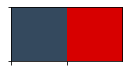

In [506]:
#define valcano colormap

volcano_pal = ["#34495e", 
               "#D70000",
              ]

sns.palplot(volcano_pal)

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


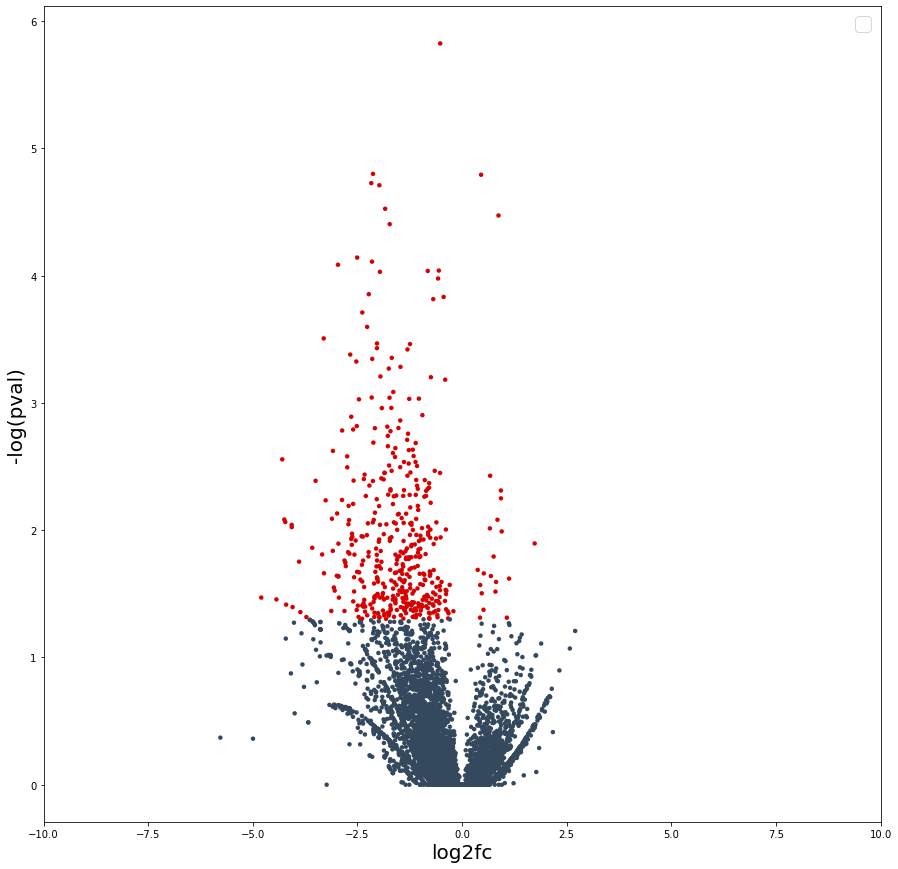

In [500]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.markerscale'] = 6
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 2

df = wald_test_Hepatocyte.summary()


###define significance annotations

def significance(row):
   if row['qval'] <= 0.05:
      return 'significant'
   else:
      return 'insignificant'
df['significance'] =  df.apply(lambda row: significance(row), axis=1)

df=df.dropna()

df['-log(pval)'] = -np.log10(df['qval'])

# plot wald test results as volcano plot

g= sns.scatterplot(data=df,
                x='log2fc',
                y='-log(pval)',
                s=20,
                linewidth=0,
                hue='significance',
                palette=volcano_pal
        )

g.set(xlim=(-10, 10))
g.set(ylim=(0, 10))

g.legend([])

# MAST DE

In [281]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri

import anndata2ri



In [282]:
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [283]:
rpy2.__version__

'3.3.6'

In [284]:
# import rpy2.robjects.numpy2ri
# rpy2.robjects.numpy2ri.activate()

In [285]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
# library(slingshot)
# library(monocle)
# library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

In [286]:
##make a count matriX for test
adata_test = adata_norm.copy()

adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) # recompute number of genes expressed per cell

In [287]:
## matrix indeices need to be integers for R . . .

adata_index = adata.obs.index



In [288]:
###replace indicies with integers
adata_test.obs = adata_test.obs.reindex(index = list(range(5434)))

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64', name='index'), …


In [289]:
###remove unstructered annotations until indicies can be found...
adata_test.uns = {}

In [290]:
adata.obs['CellType'].unique().tolist()

['Hepatocyte', 'mc38', 'Kupffer', 'MSC', 'Lymphocyte', 'Myeloid', 'LSEC']

In [293]:
%%R -i adata_test -o sca_hepatocyte

#-o hepatocyte_de -o mc38_de



#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")




#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

#Create data subsets for liver and tumor subpopulations
sca_hepatocyte <- subset(sca, with(colData(sca), CellType=='Hepatocyte'))
sca_mc38 <- subset(sca, with(colData(sca), CellType=='mc38'))

#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_hepatocyte))
print(dim(sca_mc38))
print("")


sca_hepatocyte_filt = sca_hepatocyte[rowSums(assay(sca_hepatocyte)) != 0, ]
sca_mc38_filt = sca_mc38[rowSums(assay(sca_mc38)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_hepatocyte_filt))
print(dim(sca_mc38_filt))



#Define & run hurdle model - hepatocyte
zlmCond_hepatocyte <- zlm(formula = ~tissue + batch + n_genes, sca=sca_hepatocyte_filt)

summaryCond_hepatocyte <- summary(zlmCond_hepatocyte, doLRT='tissuetumor')
summaryDt_hepatocyte <- summaryCond_hepatocyte$datatable

result_hepatocyte <- merge(summaryDt_hepatocyte[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_hepatocyte[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_hepatocyte[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
hepatocyte_de = result_hepatocyte[result_hepatocyte$FDR<0.05,, drop=F]
hepatocyte_de = hepatocyte_de[order(hepatocyte_de$FDR),]






#Define & run hurdle model - mc38
zlmCond_mc38 <- zlm(formula = ~tissue + batch + n_genes, sca=sca_mc38_filt)

summaryCond_mc38 <- summary(zlmCond_mc38, doLRT='tissuetumor')
summaryDt_mc38 <- summaryCond_mc38$datatable

result_mc38 <- merge(summaryDt_mc38[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_mc38[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_mc38[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
mc38_de = result_mc38[result_mc38$FDR<0.05,, drop=F]
mc38_de = mc38_de[order(mc38_de$FDR),]




R[write to console]: `fData` has no primerid.  I'll make something up.

R[write to console]: `cData` has no wellKey.  I'll make something up.

R[write to console]: Assuming data assay in position 1, with name X is log-transformed.

R[write to console]: Error: logical subscript contains NAs




Error: logical subscript contains NAs


In [521]:
hepatocyte_de

,primerid,Pr(>Chisq),coef,FDR
1,mm10_Gmcl1,1.691476e-11,0.008782,3.292795e-07
2,mm10_1700123O12Rik,2.670294e-10,0.003030,2.599130e-06
3,mm10_Dpyd,1.127902e-08,-0.294198,5.489218e-05
4,mm10_Rnf167,1.126622e-08,0.065295,5.489218e-05
5,mm10_Ubxn8,1.606948e-08,-0.039826,6.256491e-05
...,...,...,...,...
69,mm10_Gck,1.866676e-04,0.144270,4.977887e-02
70,mm10_Hpx,1.801752e-04,0.199619,4.977887e-02
71,mm10_Peg3,1.798788e-04,0.216216,4.977887e-02
72,mm10_Phf10,1.840086e-04,0.001365,4.977887e-02


In [518]:

mc38_de['-logQ'] = -np.log(mc38_de['FDR'])

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [532]:
adata_norm[adata_norm.obs['CellType'] == 'Hepatocyte']

AssertionError: Don’t call _normalize_index with non-categorical/string names

In [523]:
%%R -i adata_test -o Myeloid_de -o Lymphocyte_de

#-o Myeloid_de

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")




#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

#Create data subsets for liver and tumor subpopulations
sca_Myeloid <- subset(sca, with(colData(sca), CellType=='Myeloid'))
sca_Lymphocyte <- subset(sca, with(colData(sca), CellType=='Lymphocyte'))

#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_Myeloid))
print(dim(sca_Lymphocyte))
print("")


sca_Myeloid_filt = sca_Myeloid[rowSums(assay(sca_Myeloid)) != 0, ]
sca_Lymphocyte_filt = sca_Lymphocyte[rowSums(assay(sca_Lymphocyte)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_Myeloid_filt))
print(dim(sca_Lymphocyte_filt))



#Define & run hurdle model - Myeloid
zlmCond_Myeloid <- zlm(formula = ~tissue + batch + n_genes, sca=sca_Myeloid_filt)

summaryCond_Myeloid <- summary(zlmCond_Myeloid, doLRT='tissuetumor')
summaryDt_Myeloid <- summaryCond_Myeloid$datatable

result_Myeloid <- merge(summaryDt_Myeloid[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_Myeloid[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_Myeloid[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
Myeloid_de = result_Myeloid[result_Myeloid$FDR<0.05,, drop=F]
Myeloid_de = Myeloid_de[order(Myeloid_de$FDR),]






#Define & run hurdle model - Lymphocyte
zlmCond_Lymphocyte <- zlm(formula = ~tissue + batch + n_genes, sca=sca_Lymphocyte_filt)

summaryCond_Lymphocyte <- summary(zlmCond_Lymphocyte, doLRT='tissuetumor')
summaryDt_Lymphocyte <- summaryCond_Lymphocyte$datatable

result_Lymphocyte <- merge(summaryDt_Lymphocyte[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_Lymphocyte[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_Lymphocyte[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
Lymphocyte_de = result_Lymphocyte[result_Lymphocyte$FDR<0.05,, drop=F]
Lymphocyte_de = Lymphocyte_de[order(Lymphocyte_de$FDR),]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
R[write to console]: `fData` has no primerid.  I'll make something up.

R[write to console]: `cData` has no wellKey.  I'll make something up.

R[write to console]: Assuming data assay in position 1, with name X is log-transformed.



[1] "Dimensions before subsetting:"
[1] 24917   822
[1] 24917   150
[1] ""
[1] "Dimensions after subsetting:"
[1] 17325   822
[1] 12044   150


R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   0% with 0 failures
R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   2% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   4% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   5% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [====================>-----------------------]  48% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================>-----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  50% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  52% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  53% with 0 failures
R[write to console]: 
R[write to console]:  Co

R[write to console]: 
R[write to console]:  Completed [=========================================>--]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  98% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>] 100% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============================================] 100% with 0 failures
                                                                              
R[write to console]: 
R[write to console]: 
Done!

R[write to conso

R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  43% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  45% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  46% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  47% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [======================================>-----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  91% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  93% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  94% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=========================================>--]  94% with 0 failures
R[write to console]: 
R[write to console]:  Co

R[write to console]: 
R[write to console]:  Completed [===============>----------------------------]  35% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===============>----------------------------]  36% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===============>----------------------------]  37% with 0 failures
R[write to console]: 
R[write to console]:  Completed [================>---------------------------]  38% with 0 failures
R[write to console]: 
R[write to console]:  Completed [================>---------------------------]  39% with 0 failures
R[write to console]: 
R[write to console]:  Completed [================>---------------------------]  40% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  40% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  41% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [====================================>-------]  83% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================================>-------]  84% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================================>-------]  85% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================================>------]  85% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================================>------]  86% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================================>------]  87% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================================>-----]  88% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================================>-----]  89% with 0 failures
R[write to console]: 
R[write to console]:  Co

R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  28% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  29% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  30% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  31% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=============>------------------------------]  31% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=============>------------------------------]  32% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=============>------------------------------]  33% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==============>-----------------------------]  33% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [=================================>----------]  76% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================================>----------]  77% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================================>----------]  78% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  78% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  79% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  80% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  81% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================================>--------]  81% with 0 failures
R[write to console]: 
R[write to console]:  Co

# Diffxpy Continuous DE

In [158]:
continuous_test = de.test. continuous_1d(
    data=adata_norm_TAM.X,
    
    sample_description=adata_norm_TAM.obs,
    
     gene_names=adata_norm_TAM.var_names,
#     grouping=adata_norm_Hepatocyte.obs.tissue

     formula_loc="~ 1 + prox_2",
     formula_scale="~ 1",
     factor_loc_totest="prox_2",
     continuous='prox_2',
     #size_factors='size_factors',
    
    
    ###convert to float64
    dtype='float64',
    backend='numpy'
    
    
)

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


training location model: True
training scale model: True
iter   0: ll=10850348.166224
iter   1: ll=10806552.144979, converged: 0.00% (loc: 35.65%, scale update: False), in 3.70sec
caught 29 linalg singular matrix errors
iter   2: ll=10799597.215901, converged: 0.00% (loc: 59.92%, scale update: False), in 3.42sec
iter   3: ll=10797594.540542, converged: 0.00% (loc: 59.92%, scale update: False), in 3.14sec
iter   4: ll=10796666.878774, converged: 0.00% (loc: 61.06%, scale update: False), in 2.77sec
iter   5: ll=10796043.647494, converged: 0.00% (loc: 66.28%, scale update: False), in 3.12sec
iter   6: ll=1217900.784644, converged: 33.50% (loc: 33.50%, scale update: True), in 85.09sec
caught 28 linalg singular matrix errors
iter   7: ll=1208693.558484, converged: 33.50% (loc: 51.82%, scale update: False), in 3.89sec
iter   8: ll=1207136.259365, converged: 33.50% (loc: 56.38%, scale update: False), in 4.21sec
iter   9: ll=1206418.191131, converged: 33.50% (loc: 67.50%, scale update: False),

iter  77: ll=1132017.836866, converged: 99.78% (loc: 99.90%, scale update: False), in 0.46sec
iter  78: ll=1132012.246441, converged: 99.83% (loc: 99.83%, scale update: True), in 32.60sec
iter  79: ll=1132012.245831, converged: 99.83% (loc: 99.88%, scale update: False), in 0.55sec
iter  80: ll=1132012.245626, converged: 99.83% (loc: 99.90%, scale update: False), in 0.46sec
iter  81: ll=1132012.245460, converged: 99.83% (loc: 99.90%, scale update: False), in 0.44sec
iter  82: ll=1132012.245324, converged: 99.83% (loc: 99.90%, scale update: False), in 0.42sec
iter  83: ll=1132012.245210, converged: 99.83% (loc: 99.91%, scale update: False), in 0.87sec
iter  84: ll=1132012.245074, converged: 99.88% (loc: 99.88%, scale update: True), in 42.28sec
iter  85: ll=1132012.244555, converged: 99.88% (loc: 99.90%, scale update: False), in 0.90sec
iter  86: ll=1132012.244413, converged: 99.88% (loc: 99.91%, scale update: False), in 0.73sec
iter  87: ll=1132012.244299, converged: 99.88% (loc: 99.91%,

iter 163: ll=1132012.238903, converged: 99.96% (loc: 99.98%, scale update: False), in 0.35sec
iter 164: ll=1132012.238831, converged: 99.96% (loc: 99.98%, scale update: False), in 0.32sec
iter 165: ll=1132012.238784, converged: 99.96% (loc: 99.98%, scale update: False), in 0.32sec
iter 166: ll=1132012.238753, converged: 99.96% (loc: 99.98%, scale update: False), in 0.31sec
iter 167: ll=1132012.238733, converged: 99.96% (loc: 99.98%, scale update: False), in 0.31sec
iter 168: ll=1132012.238565, converged: 99.97% (loc: 99.97%, scale update: True), in 35.93sec
iter 169: ll=1132012.238421, converged: 99.97% (loc: 99.98%, scale update: False), in 0.38sec
iter 170: ll=1132012.238329, converged: 99.97% (loc: 99.98%, scale update: False), in 0.35sec
iter 171: ll=1132012.238270, converged: 99.97% (loc: 99.98%, scale update: False), in 0.39sec
iter 172: ll=1132012.238233, converged: 99.97% (loc: 99.98%, scale update: False), in 0.34sec
iter 173: ll=1132012.238209, converged: 99.97% (loc: 99.98%,

iter 251: ll=1132012.216819, converged: 99.99% (loc: 100.00%, scale update: False), in 0.37sec
iter 252: ll=1132012.216784, converged: 99.99% (loc: 99.99%, scale update: True), in 0.36sec
iter 253: ll=1132012.216767, converged: 99.99% (loc: 99.99%, scale update: False), in 0.31sec
iter 254: ll=1132012.216764, converged: 99.99% (loc: 99.99%, scale update: False), in 0.31sec
iter 255: ll=1132012.216764, converged: 99.99% (loc: 100.00%, scale update: False), in 0.31sec
iter 256: ll=1132012.216764, converged: 99.99% (loc: 100.00%, scale update: False), in 0.35sec
iter 257: ll=1132012.216764, converged: 99.99% (loc: 100.00%, scale update: False), in 0.36sec
iter 258: ll=1132012.216754, converged: 99.99% (loc: 99.99%, scale update: True), in 0.82sec
iter 259: ll=1132012.216749, converged: 99.99% (loc: 99.99%, scale update: False), in 0.32sec
iter 260: ll=1132012.216748, converged: 99.99% (loc: 99.99%, scale update: False), in 0.30sec
iter 261: ll=1132012.216748, converged: 99.99% (loc: 100.0

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/array/core.py:2707: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


In [161]:
continuous_test_df = continuous_test.summary()

In [167]:
##qval cutoff
gene_frame = continuous_test_df[continuous_test_df.sort_values('qval', )['qval'] <= 0.05]



<ipython-input-167-49a92488b5ad>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gene_frame = continuous_test_df[continuous_test_df.sort_values('qval', )['qval'] <= 0.05]


In [168]:
##fold change cutoff
gene_frame_2 = gene_frame[gene_frame.log2fc >= 2]



In [169]:
gene_idx = continuous_test._idx_genes(genes=gene_frame_2['gene'].tolist()

)

In [185]:
xcoord, data = continuous_test._continuous_interpolation(idx=gene_idx[0])

In [186]:
### after tranforming, data has number of values, equal to filtered results
data = data.T

In [187]:
temp=pd.DataFrame(data)

In [201]:
#temp.index = continuous_test.summary().iloc[list(gene_idx)]['gene'].str[5:]

In [189]:
temp_2 = temp.div(temp.sum(axis=1), axis=0)

In [198]:
temp_3=temp_2[~(temp_2 > 0.05).any(1)]

In [199]:
temp_3.shape

(36, 100)

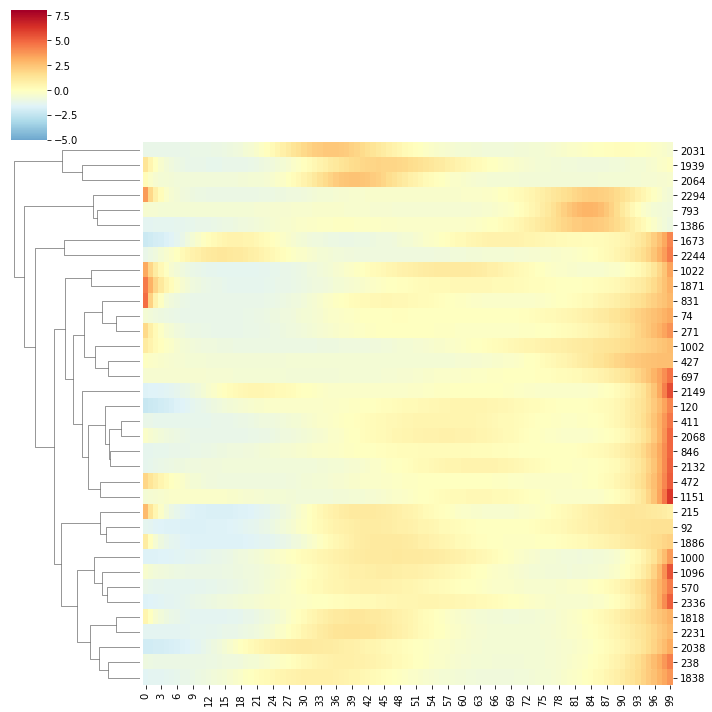

In [200]:
plt.rcParams['figure.figsize'] = [10, 20]

# z_scoreint or None, optional
# Either 0 (rows) or 1 (columns).





g =sns.clustermap(data=temp_3,
             metric='cityblock', #defualt euclidean   #canberra
             method='average',
            z_score=0,
           cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
               col_cluster=False      
           )

#plt.savefig('/Users/derekbogdanoff/Desktop/heatmap_spatial.svg', bbox_inches='tight')